### Példa generátorokra: első *N* pitagoraszi számhármas és Fibonacci-szám előállítása, sejtautomata

[(3, 4, 5), (6, 8, 10), (5, 12, 13), (9, 12, 15), (8, 15, 17)]
[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181]


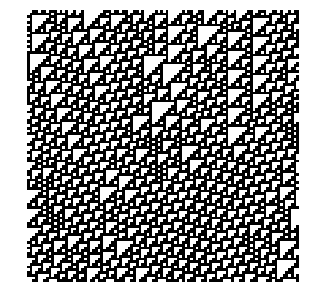

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



def int_generator():
    i = 1
    while True:
        yield i
        i += 1
pyth_generator = ((a,b,c) for c in int_generator() for b in range(1,c) for a in range(1,b) if a**2+b**2==c**2)
print(list(itertools.islice(pyth_generator, 5)))



def fibo_generator():
    a, b = 0, 1
    while True:
        yield a
        a, b = b, a+b
print(list(itertools.islice(fibo_generator(), 20)))



def cellular_generator(rule, size):
    rule_bin = np.array([int(b) for b in np.binary_repr(rule, 8)])
    state = np.random.randint(2, size=size)
    while True:
        yield state
        state = rule_bin[7 - (np.roll(state, 1)*4 + state*2 + np.roll(state, -1))]
plt.figure(figsize=[5, 5])
plt.imshow(np.vstack(itertools.islice(cellular_generator(110, 100), 100)), cmap=plt.cm.binary)
plt.axis('off');

### Függvények listája a map() argumentuában

In [2]:
flist = [lambda x: x*2, lambda x: x**2]
for i in range(10):
    print(list(map(lambda x: x(i), flist)))

[0, 0]
[2, 1]
[4, 4]
[6, 9]
[8, 16]
[10, 25]
[12, 36]
[14, 49]
[16, 64]
[18, 81]


### Korutinok kooperatív ütemezése

In [3]:
import queue

class Task(object):
    num_tasks = 0

    def __init__(self, func):
        self.func = func
        self.id = Task.num_tasks
        Task.num_tasks += 1

    def run(self):
        return self.func.send(None)

class Scheduler(object):
    def __init__(self):
        self.ready_queue = queue.Queue()
        self.tasks = {}

    def add_task(self, task):
        self.tasks[task.id] = task
        self.ready_queue.put(task)
        return task.id

    def start(self):
        while self.tasks:
            task = self.ready_queue.get()
            try:
                task.run()
            except StopIteration as e:
                print('Task %d exited with code %d. ' % (task.id, e.value))
                del self.tasks[task.id]
            else:
                self.ready_queue.put(task)
        print('Nothing to schedule, terminating.')

def task0():
    for i in range(5):
        print('Hello from task 0.')
        yield
    return 0

def task1():
    for i in range(10):
        print('Hello from task 1.')
        yield
    return 0
        
scheduler = Scheduler()
scheduler.add_task(Task(task0()))
scheduler.add_task(Task(task1()))
scheduler.start()

Hello from task 0.
Hello from task 1.
Hello from task 0.
Hello from task 1.
Hello from task 0.
Hello from task 1.
Hello from task 0.
Hello from task 1.
Hello from task 0.
Hello from task 1.
Task 0 exited with code 0. 
Hello from task 1.
Hello from task 1.
Hello from task 1.
Hello from task 1.
Hello from task 1.
Task 1 exited with code 0. 
Nothing to schedule, terminating.


### Kódrészlet futásidejének mérése elegánsan

In [4]:
import time
from contextlib import contextmanager

@contextmanager
def timethis(name):
    t1 = time.time()
    yield
    t2 = time.time()
    print('Runtime of %s: %0.1f ms.' % (name, (t2-t1)*1000))

with timethis('LOOP1'):
    i = 0
    while i<1000:
        i += 1

with timethis('LOOP2'):
    i = 0
    while i<1000000:
        i += 1

Runtime of LOOP1: 0.4 ms.
Runtime of LOOP2: 243.0 ms.


In [5]:
def timeit(func):
    def wrapper(*args, **kwargs):
        import time
        t1 = time.time()
        res = func(*args, **kwargs)
        t2 = time.time()
        print('Runtime of %s: %.1f ms.' % (func.__name__, (t2-t1)*1000))
        return res
    return wrapper

@timeit
def testfunc():
    i = 0
    while i<1000000:
        i += 1
        
testfunc()

Runtime of testfunc: 122.1 ms.


### Függvények kimenetét fájlba átirányító dekorátor

In [6]:
def output2file(func):
    def wrapper(*args, **kwargs):
        import sys
        filename = 'log.txt'
        file = open(filename,'a')
        file.write('Function ' + func.__name__ + ' called. Output:\n')
        stdout_orig = sys.stdout
        sys.stdout = file
        res = func(*args, **kwargs)
        sys.stdout = stdout_orig
        file.write('Function ' + func.__name__ + ' returned ' + str(res) + '.\n')
        file.close()
        return res
    return wrapper

@output2file
def testfunc(x):
    for i in range(10):
        print(i*x)
    return 0

testfunc(7)
file = open('log.txt')
for line in file:
    print(line, end='')
file.close()

Function testfunc called. Output:
0
7
14
21
28
35
42
49
56
63
Function testfunc returned 0.


### Listák együttes rendezése

In [7]:
l1 = [3, 2, 1, 5, 4]
l2 = ['a', 'b', 'c', 'd', 'e']

l1, l2 = [list(t) for t in zip(*sorted(zip(l1, l2)))]

print(l1)
print(l2)

[1, 2, 3, 4, 5]
['c', 'b', 'a', 'e', 'd']


### Mutable default paraméter kihasználása eredmények cache-eléséhez

In [8]:
def func(x, cache={}):
    try:
        result = cache[x]
        print('Cache hit.')
    except KeyError:
        result = x**2
        cache[x] = result
        print('Cache miss.')
    return result

print(func(10))
print(func(4))
print(func(10))

Cache miss.
100
Cache miss.
16
Cache hit.
100
